### Import libs

In [0]:
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load MNIST

In [0]:
(train_x, train_y), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x = (train_x - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

### The Generator

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
                                     use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', 
                                     use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

#### Use the untrained generator to create an image

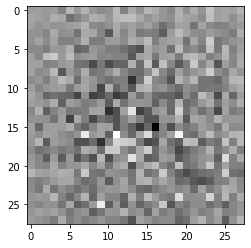

In [10]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

#### Use the untrained discriminator to classify the generated image as real or fake

In [13]:
decision = discriminator(generated_image)

print (decision)

tf.Tensor([[0.00150368]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
    
    print ('> Epoch | Batch | Generator Loss | Disc Loss')

    total_time = 0
    losses = []

    for epoch in range(epochs):
        start_time = time.time()

        batch_count = 1

        for image_batch in dataset:

            gen_loss, disc_loss = train_step(image_batch)

            print ('> {} | {}/{} | {} | {}'.format(epoch + 1, batch_count, 
                                                        BATCH_SIZE,
                                                        gen_loss, disc_loss))
            
            batch_count += 1

        losses.append((gen_loss, disc_loss))

        # Produce images for the GIF as we go
        #display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch time is {} sec'.format(time.time()-start_time))        

    print('Total training time is {} sec'.format(time.time()-start_time))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)
    
    return losses

**Generate and save images**


In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model

> Epoch | Batch | Generator Loss | Disc Loss
> 1 | 1/256 | 0.6822307705879211 | 1.3762784004211426
> 1 | 2/256 | 0.6507169008255005 | 1.3612067699432373
> 1 | 3/256 | 0.6217871308326721 | 1.3375062942504883
> 1 | 4/256 | 0.6003689765930176 | 1.3157174587249756
> 1 | 5/256 | 0.5865892171859741 | 1.2888752222061157
> 1 | 6/256 | 0.5745196342468262 | 1.2690563201904297
> 1 | 7/256 | 0.5656682848930359 | 1.2491317987442017
> 1 | 8/256 | 0.5610953569412231 | 1.2240188121795654
> 1 | 9/256 | 0.5593338012695312 | 1.2012057304382324
> 1 | 10/256 | 0.5567517280578613 | 1.184633731842041
> 1 | 11/256 | 0.5523654222488403 | 1.1644248962402344
> 1 | 12/256 | 0.5473145842552185 | 1.1542377471923828
> 1 | 13/256 | 0.5426034331321716 | 1.1436975002288818
> 1 | 14/256 | 0.5335378050804138 | 1.1424977779388428
> 1 | 15/256 | 0.5250803232192993 | 1.139609694480896
> 1 | 16/256 | 0.515799880027771 | 1.1449577808380127
> 1 | 17/256 | 0.5035611987113953 | 1.154059886932373
> 1 | 18/256 | 0.489309161901474 

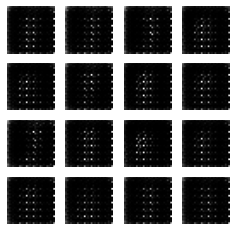

Epoch time is 27.058287858963013 sec
> 2 | 1/256 | 0.777114987373352 | 1.3009090423583984
> 2 | 2/256 | 0.7882035970687866 | 1.2913485765457153
> 2 | 3/256 | 0.8093965649604797 | 1.2605962753295898
> 2 | 4/256 | 0.8218916654586792 | 1.2362865209579468
> 2 | 5/256 | 0.8200470209121704 | 1.2014493942260742
> 2 | 6/256 | 0.8401871919631958 | 1.174372911453247
> 2 | 7/256 | 0.8659578561782837 | 1.1391701698303223
> 2 | 8/256 | 0.8739242553710938 | 1.12265145778656
> 2 | 9/256 | 0.912758469581604 | 1.0889036655426025
> 2 | 10/256 | 0.9333687424659729 | 1.1060863733291626
> 2 | 11/256 | 0.9283946752548218 | 1.1079206466674805
> 2 | 12/256 | 0.9537849426269531 | 1.039484977722168
> 2 | 13/256 | 0.9516493082046509 | 1.0357449054718018
> 2 | 14/256 | 0.954979658126831 | 1.02547025680542
> 2 | 15/256 | 0.9793967008590698 | 1.0176405906677246
> 2 | 16/256 | 0.9684281349182129 | 0.9945778846740723
> 2 | 17/256 | 0.980000376701355 | 0.9954334497451782
> 2 | 18/256 | 1.0075702667236328 | 1.022327423

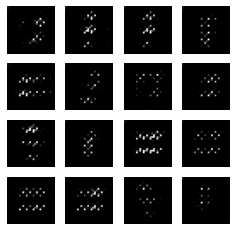

Epoch time is 23.893149375915527 sec
> 3 | 1/256 | 0.6695858836174011 | 1.6428101062774658
> 3 | 2/256 | 0.6691532135009766 | 1.6001219749450684
> 3 | 3/256 | 0.6936910152435303 | 1.5983437299728394
> 3 | 4/256 | 0.6719765663146973 | 1.6625280380249023
> 3 | 5/256 | 0.6528564095497131 | 1.6195003986358643
> 3 | 6/256 | 0.6379870772361755 | 1.6649861335754395
> 3 | 7/256 | 0.6406570672988892 | 1.7090452909469604
> 3 | 8/256 | 0.6342856884002686 | 1.6574727296829224
> 3 | 9/256 | 0.644618809223175 | 1.7229063510894775
> 3 | 10/256 | 0.6721077561378479 | 1.7177574634552002
> 3 | 11/256 | 0.6836414337158203 | 1.6625999212265015
> 3 | 12/256 | 0.6839249134063721 | 1.629996418952942
> 3 | 13/256 | 0.6976794600486755 | 1.6461005210876465
> 3 | 14/256 | 0.7045712471008301 | 1.5781604051589966
> 3 | 15/256 | 0.7070853114128113 | 1.6051459312438965
> 3 | 16/256 | 0.7201952934265137 | 1.5889296531677246
> 3 | 17/256 | 0.7234354615211487 | 1.5334744453430176
> 3 | 18/256 | 0.765302300453186 | 1.48

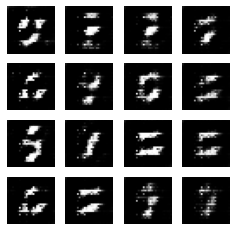

Epoch time is 23.775396585464478 sec
> 4 | 1/256 | 0.8981314301490784 | 1.1661813259124756
> 4 | 2/256 | 0.9295504093170166 | 1.1649396419525146
> 4 | 3/256 | 0.9286529421806335 | 1.1565130949020386
> 4 | 4/256 | 0.9308332800865173 | 1.1438319683074951
> 4 | 5/256 | 0.9042134881019592 | 1.130624532699585
> 4 | 6/256 | 0.8537949323654175 | 1.1271836757659912
> 4 | 7/256 | 0.8575952649116516 | 1.1445527076721191
> 4 | 8/256 | 0.8631836771965027 | 1.1780970096588135
> 4 | 9/256 | 0.893550455570221 | 1.1442530155181885
> 4 | 10/256 | 0.914675772190094 | 1.1297097206115723
> 4 | 11/256 | 0.9425479769706726 | 1.1400433778762817
> 4 | 12/256 | 0.9294402599334717 | 1.1341676712036133
> 4 | 13/256 | 0.904903769493103 | 1.169086217880249
> 4 | 14/256 | 0.8701673746109009 | 1.1731352806091309
> 4 | 15/256 | 0.839518129825592 | 1.1809104681015015
> 4 | 16/256 | 0.851793110370636 | 1.1586344242095947
> 4 | 17/256 | 0.8883881568908691 | 1.1476951837539673
> 4 | 18/256 | 0.9298533797264099 | 1.148236

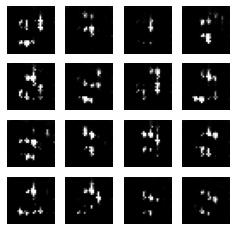

Epoch time is 23.71824049949646 sec
> 5 | 1/256 | 0.7819773554801941 | 1.5353353023529053
> 5 | 2/256 | 0.7760213017463684 | 1.5585235357284546
> 5 | 3/256 | 0.7625998258590698 | 1.520227313041687
> 5 | 4/256 | 0.7455554604530334 | 1.5356379747390747
> 5 | 5/256 | 0.7102605104446411 | 1.5635082721710205
> 5 | 6/256 | 0.6784045100212097 | 1.560800313949585
> 5 | 7/256 | 0.7454872131347656 | 1.4907160997390747
> 5 | 8/256 | 0.7529401183128357 | 1.5260897874832153
> 5 | 9/256 | 0.7755180597305298 | 1.4686098098754883
> 5 | 10/256 | 0.809357762336731 | 1.4468927383422852
> 5 | 11/256 | 0.792563259601593 | 1.474064826965332
> 5 | 12/256 | 0.7688357830047607 | 1.4781215190887451
> 5 | 13/256 | 0.759577751159668 | 1.4655399322509766
> 5 | 14/256 | 0.7358014583587646 | 1.5039175748825073
> 5 | 15/256 | 0.7491681575775146 | 1.4568407535552979
> 5 | 16/256 | 0.7597149610519409 | 1.4719239473342896
> 5 | 17/256 | 0.7537579536437988 | 1.4526325464248657
> 5 | 18/256 | 0.7704867124557495 | 1.496850

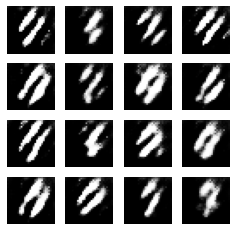

Epoch time is 23.930962562561035 sec
> 6 | 1/256 | 0.8206779360771179 | 1.3661589622497559
> 6 | 2/256 | 0.7999241352081299 | 1.348949670791626
> 6 | 3/256 | 0.7975649833679199 | 1.3574107885360718
> 6 | 4/256 | 0.758932888507843 | 1.3102495670318604
> 6 | 5/256 | 0.7412365674972534 | 1.372199535369873
> 6 | 6/256 | 0.7278697490692139 | 1.2955107688903809
> 6 | 7/256 | 0.7523824572563171 | 1.2648229598999023
> 6 | 8/256 | 0.8012972474098206 | 1.2853941917419434
> 6 | 9/256 | 0.8289414048194885 | 1.275399923324585
> 6 | 10/256 | 0.8777584433555603 | 1.2726703882217407
> 6 | 11/256 | 0.8530305624008179 | 1.2860839366912842
> 6 | 12/256 | 0.82394939661026 | 1.2480554580688477
> 6 | 13/256 | 0.775759220123291 | 1.273517370223999
> 6 | 14/256 | 0.7872705459594727 | 1.2173144817352295
> 6 | 15/256 | 0.7906295657157898 | 1.2206807136535645
> 6 | 16/256 | 0.7852312922477722 | 1.2200160026550293
> 6 | 17/256 | 0.8165141344070435 | 1.1884729862213135
> 6 | 18/256 | 0.86228346824646 | 1.215051412

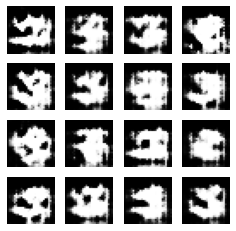

Epoch time is 23.82003164291382 sec
> 7 | 1/256 | 0.8280279040336609 | 1.3187494277954102
> 7 | 2/256 | 0.8271893262863159 | 1.280644416809082
> 7 | 3/256 | 0.7878587245941162 | 1.301486611366272
> 7 | 4/256 | 0.8358266353607178 | 1.2604414224624634
> 7 | 5/256 | 0.7677547931671143 | 1.2850818634033203
> 7 | 6/256 | 0.8146249651908875 | 1.3145277500152588
> 7 | 7/256 | 0.7877249121665955 | 1.2784533500671387
> 7 | 8/256 | 0.8102384209632874 | 1.3107919692993164
> 7 | 9/256 | 0.8075025677680969 | 1.282104253768921
> 7 | 10/256 | 0.7717483043670654 | 1.2986202239990234
> 7 | 11/256 | 0.8010722994804382 | 1.2859644889831543
> 7 | 12/256 | 0.8263751864433289 | 1.2406479120254517
> 7 | 13/256 | 0.8089612722396851 | 1.3680669069290161
> 7 | 14/256 | 0.8395019769668579 | 1.2892460823059082
> 7 | 15/256 | 0.8400794267654419 | 1.2852940559387207
> 7 | 16/256 | 0.8375915288925171 | 1.311662197113037
> 7 | 17/256 | 0.7956717014312744 | 1.3176875114440918
> 7 | 18/256 | 0.8175954222679138 | 1.3201

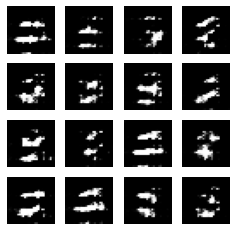

Epoch time is 23.839632987976074 sec
> 8 | 1/256 | 1.0123344659805298 | 1.184546947479248
> 8 | 2/256 | 1.0584334135055542 | 1.1567596197128296
> 8 | 3/256 | 1.0894838571548462 | 1.212786316871643
> 8 | 4/256 | 1.0925534963607788 | 1.172171711921692
> 8 | 5/256 | 0.9676957130432129 | 1.2421391010284424
> 8 | 6/256 | 0.9723860025405884 | 1.269124984741211
> 8 | 7/256 | 0.9774324893951416 | 1.2773550748825073
> 8 | 8/256 | 0.9310382008552551 | 1.280407428741455
> 8 | 9/256 | 0.9068825840950012 | 1.3286696672439575
> 8 | 10/256 | 0.9606747627258301 | 1.317873239517212
> 8 | 11/256 | 0.9796903729438782 | 1.4838857650756836
> 8 | 12/256 | 0.8947410583496094 | 1.3855938911437988
> 8 | 13/256 | 0.8046948313713074 | 1.404611587524414
> 8 | 14/256 | 0.7604860067367554 | 1.4416005611419678
> 8 | 15/256 | 0.7766868472099304 | 1.4439036846160889
> 8 | 16/256 | 0.8780208826065063 | 1.497225284576416
> 8 | 17/256 | 0.9096729755401611 | 1.443939208984375
> 8 | 18/256 | 0.8196451663970947 | 1.52696061

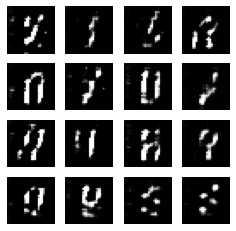

Epoch time is 23.93851900100708 sec
> 9 | 1/256 | 1.1925642490386963 | 0.9679993987083435
> 9 | 2/256 | 1.1421563625335693 | 1.0027209520339966
> 9 | 3/256 | 1.1470317840576172 | 0.9378101825714111
> 9 | 4/256 | 1.2426055669784546 | 0.9640523195266724
> 9 | 5/256 | 1.1760189533233643 | 0.9521142840385437
> 9 | 6/256 | 1.1865664720535278 | 1.0662471055984497
> 9 | 7/256 | 1.1467775106430054 | 1.0219979286193848
> 9 | 8/256 | 1.1262545585632324 | 1.0470722913742065
> 9 | 9/256 | 1.1734235286712646 | 1.068272352218628
> 9 | 10/256 | 1.1369566917419434 | 1.0320098400115967
> 9 | 11/256 | 1.0732862949371338 | 1.093979835510254
> 9 | 12/256 | 1.087354302406311 | 1.167027235031128
> 9 | 13/256 | 1.0519483089447021 | 1.181754469871521
> 9 | 14/256 | 1.0125770568847656 | 1.1710841655731201
> 9 | 15/256 | 1.0049325227737427 | 1.2477275133132935
> 9 | 16/256 | 0.9739489555358887 | 1.324301838874817
> 9 | 17/256 | 0.9635941386222839 | 1.3668030500411987
> 9 | 18/256 | 0.9161621332168579 | 1.389208

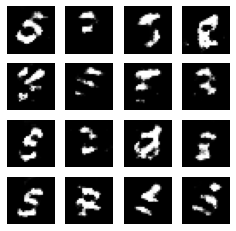

Epoch time is 23.77615451812744 sec
> 10 | 1/256 | 0.9141878485679626 | 1.3190498352050781
> 10 | 2/256 | 0.9178150296211243 | 1.3005316257476807
> 10 | 3/256 | 0.9222167730331421 | 1.2287077903747559
> 10 | 4/256 | 0.8822797536849976 | 1.3045811653137207
> 10 | 5/256 | 0.8762193918228149 | 1.3281071186065674
> 10 | 6/256 | 0.8577406406402588 | 1.3985540866851807
> 10 | 7/256 | 0.8164863586425781 | 1.4544541835784912
> 10 | 8/256 | 0.8156943917274475 | 1.3732657432556152
> 10 | 9/256 | 0.8320443630218506 | 1.433896541595459
> 10 | 10/256 | 0.8837936520576477 | 1.4363701343536377
> 10 | 11/256 | 0.8111101388931274 | 1.4823322296142578
> 10 | 12/256 | 0.798110842704773 | 1.4566725492477417
> 10 | 13/256 | 0.7976316213607788 | 1.4439771175384521
> 10 | 14/256 | 0.8080340623855591 | 1.4261715412139893
> 10 | 15/256 | 0.8282839059829712 | 1.4321093559265137
> 10 | 16/256 | 0.8311305046081543 | 1.4382154941558838
> 10 | 17/256 | 0.8375599384307861 | 1.4717953205108643
> 10 | 18/256 | 0.83408

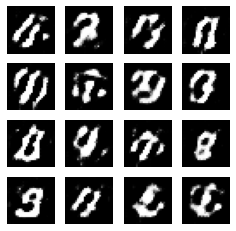

Epoch time is 23.891499757766724 sec
> 11 | 1/256 | 0.9059432744979858 | 1.2203339338302612
> 11 | 2/256 | 0.9489200711250305 | 1.2171571254730225
> 11 | 3/256 | 0.8993372917175293 | 1.2545115947723389
> 11 | 4/256 | 0.9091280698776245 | 1.2778249979019165
> 11 | 5/256 | 0.8930844068527222 | 1.228172779083252
> 11 | 6/256 | 0.9186491966247559 | 1.2212903499603271
> 11 | 7/256 | 0.9039924740791321 | 1.2282371520996094
> 11 | 8/256 | 0.8988702297210693 | 1.262892246246338
> 11 | 9/256 | 0.8896844387054443 | 1.2539355754852295
> 11 | 10/256 | 0.9115560054779053 | 1.3023812770843506
> 11 | 11/256 | 0.8976060748100281 | 1.2853727340698242
> 11 | 12/256 | 0.9148069024085999 | 1.2702031135559082
> 11 | 13/256 | 0.8792357444763184 | 1.2984328269958496
> 11 | 14/256 | 0.8673797845840454 | 1.308113932609558
> 11 | 15/256 | 0.8637591600418091 | 1.277691125869751
> 11 | 16/256 | 0.8554843068122864 | 1.3458598852157593
> 11 | 17/256 | 0.8860170841217041 | 1.3194842338562012
> 11 | 18/256 | 0.877692

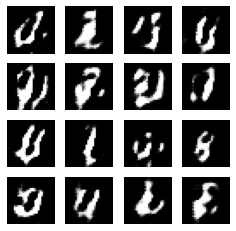

Epoch time is 23.888049125671387 sec
> 12 | 1/256 | 0.8199337124824524 | 1.3532215356826782
> 12 | 2/256 | 0.878348708152771 | 1.3112380504608154
> 12 | 3/256 | 0.9078952670097351 | 1.3775560855865479
> 12 | 4/256 | 0.973844051361084 | 1.4100213050842285
> 12 | 5/256 | 0.9146678447723389 | 1.3014962673187256
> 12 | 6/256 | 0.8469233512878418 | 1.3710777759552002
> 12 | 7/256 | 0.8704022169113159 | 1.3802582025527954
> 12 | 8/256 | 0.8322011232376099 | 1.330167531967163
> 12 | 9/256 | 0.8406751155853271 | 1.4100112915039062
> 12 | 10/256 | 0.8817375898361206 | 1.3592770099639893
> 12 | 11/256 | 0.8407312631607056 | 1.407913088798523
> 12 | 12/256 | 0.904136061668396 | 1.3597838878631592
> 12 | 13/256 | 0.8877914547920227 | 1.3652305603027344
> 12 | 14/256 | 0.873458981513977 | 1.3275337219238281
> 12 | 15/256 | 0.9099965691566467 | 1.3691444396972656
> 12 | 16/256 | 0.8449009656906128 | 1.3246999979019165
> 12 | 17/256 | 0.8795312643051147 | 1.3754942417144775
> 12 | 18/256 | 0.91042530

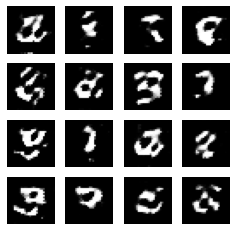

Epoch time is 23.777604341506958 sec
> 13 | 1/256 | 1.1136175394058228 | 0.9738657474517822
> 13 | 2/256 | 1.1144688129425049 | 0.9712519645690918
> 13 | 3/256 | 1.1028709411621094 | 1.0389728546142578
> 13 | 4/256 | 1.13578200340271 | 1.0195989608764648
> 13 | 5/256 | 1.0916595458984375 | 1.0542114973068237
> 13 | 6/256 | 1.1022920608520508 | 1.0773959159851074
> 13 | 7/256 | 1.08819580078125 | 1.0672383308410645
> 13 | 8/256 | 1.0469192266464233 | 1.0488126277923584
> 13 | 9/256 | 1.0572471618652344 | 1.1153727769851685
> 13 | 10/256 | 1.0558199882507324 | 1.1406646966934204
> 13 | 11/256 | 1.0549112558364868 | 1.1270959377288818
> 13 | 12/256 | 0.9682149291038513 | 1.1679641008377075
> 13 | 13/256 | 1.071951985359192 | 1.0707200765609741
> 13 | 14/256 | 0.998042106628418 | 1.1562561988830566
> 13 | 15/256 | 1.0112839937210083 | 1.1274654865264893
> 13 | 16/256 | 0.9889042377471924 | 1.1899425983428955
> 13 | 17/256 | 1.02336847782135 | 1.1647789478302002
> 13 | 18/256 | 1.0267806053

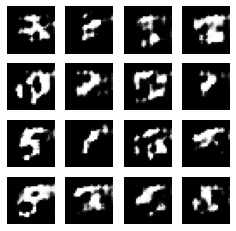

Epoch time is 23.88388729095459 sec
> 14 | 1/256 | 1.2399524450302124 | 1.0346763134002686
> 14 | 2/256 | 1.1451916694641113 | 1.0687706470489502
> 14 | 3/256 | 1.0091772079467773 | 1.0366787910461426
> 14 | 4/256 | 1.0293687582015991 | 1.0020962953567505
> 14 | 5/256 | 1.183397889137268 | 1.0607190132141113
> 14 | 6/256 | 1.3609360456466675 | 0.9823909997940063
> 14 | 7/256 | 1.3696626424789429 | 0.9987899661064148
> 14 | 8/256 | 1.1795421838760376 | 1.0541834831237793
> 14 | 9/256 | 1.0970423221588135 | 1.0079079866409302
> 14 | 10/256 | 1.0931744575500488 | 1.0001115798950195
> 14 | 11/256 | 1.2052314281463623 | 0.974532961845398
> 14 | 12/256 | 1.254807472229004 | 0.998745858669281
> 14 | 13/256 | 1.2990717887878418 | 1.053061604499817
> 14 | 14/256 | 1.20064377784729 | 1.0733259916305542
> 14 | 15/256 | 1.0939249992370605 | 1.140222430229187
> 14 | 16/256 | 1.0683614015579224 | 1.1001760959625244
> 14 | 17/256 | 1.0001351833343506 | 1.0793935060501099
> 14 | 18/256 | 1.08908486366

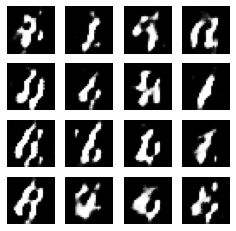

Epoch time is 23.75717568397522 sec
> 15 | 1/256 | 1.2725619077682495 | 1.1314902305603027
> 15 | 2/256 | 1.1150703430175781 | 1.1080482006072998
> 15 | 3/256 | 1.0728765726089478 | 1.1064555644989014
> 15 | 4/256 | 1.0318236351013184 | 1.1296913623809814
> 15 | 5/256 | 1.045592188835144 | 1.0852512121200562
> 15 | 6/256 | 1.263807773590088 | 1.117099404335022
> 15 | 7/256 | 1.2450560331344604 | 1.1572701930999756
> 15 | 8/256 | 1.1045466661453247 | 1.1318614482879639
> 15 | 9/256 | 1.0442850589752197 | 1.1266286373138428
> 15 | 10/256 | 1.110788345336914 | 1.0701172351837158
> 15 | 11/256 | 1.176266074180603 | 1.0934103727340698
> 15 | 12/256 | 1.2489231824874878 | 1.0803195238113403
> 15 | 13/256 | 1.257683277130127 | 1.1281602382659912
> 15 | 14/256 | 1.0755661725997925 | 1.1206066608428955
> 15 | 15/256 | 0.9967738389968872 | 1.123714804649353
> 15 | 16/256 | 1.1224074363708496 | 1.078169345855713
> 15 | 17/256 | 1.262775182723999 | 1.0817487239837646
> 15 | 18/256 | 1.277092099189

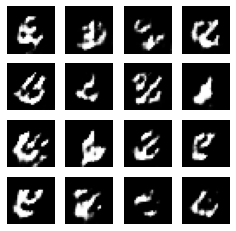

Epoch time is 23.923283576965332 sec
> 16 | 1/256 | 1.304975152015686 | 1.1384499073028564
> 16 | 2/256 | 1.2362241744995117 | 1.0888988971710205
> 16 | 3/256 | 1.17998468875885 | 1.100906252861023
> 16 | 4/256 | 1.2264909744262695 | 1.0374915599822998
> 16 | 5/256 | 1.2509771585464478 | 1.064681887626648
> 16 | 6/256 | 1.300520896911621 | 1.0978528261184692
> 16 | 7/256 | 1.370660662651062 | 0.9616836309432983
> 16 | 8/256 | 1.2813042402267456 | 1.0335921049118042
> 16 | 9/256 | 1.241272211074829 | 1.0475988388061523
> 16 | 10/256 | 1.259534239768982 | 1.0241247415542603
> 16 | 11/256 | 1.3176487684249878 | 0.9557374119758606
> 16 | 12/256 | 1.3392581939697266 | 0.9099888801574707
> 16 | 13/256 | 1.3182541131973267 | 0.9645767211914062
> 16 | 14/256 | 1.424052357673645 | 0.9850378036499023
> 16 | 15/256 | 1.4768037796020508 | 0.864301860332489
> 16 | 16/256 | 1.3164383172988892 | 0.995557427406311
> 16 | 17/256 | 1.3406243324279785 | 1.0006136894226074
> 16 | 18/256 | 1.34298610687255

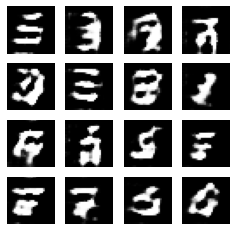

Epoch time is 23.939737796783447 sec
> 17 | 1/256 | 0.863685131072998 | 1.5781158208847046
> 17 | 2/256 | 0.9718729853630066 | 1.534271478652954
> 17 | 3/256 | 0.8617371320724487 | 1.4350104331970215
> 17 | 4/256 | 0.8070927262306213 | 1.3813341856002808
> 17 | 5/256 | 0.8216279149055481 | 1.3504323959350586
> 17 | 6/256 | 0.9497489929199219 | 1.324218511581421
> 17 | 7/256 | 1.077892541885376 | 1.2488839626312256
> 17 | 8/256 | 0.9837397336959839 | 1.3109841346740723
> 17 | 9/256 | 0.9743444323539734 | 1.2645962238311768
> 17 | 10/256 | 0.9557472467422485 | 1.2151153087615967
> 17 | 11/256 | 1.0188626050949097 | 1.0962071418762207
> 17 | 12/256 | 1.1347287893295288 | 1.0860378742218018
> 17 | 13/256 | 1.1740461587905884 | 1.1551296710968018
> 17 | 14/256 | 1.2561850547790527 | 1.105242133140564
> 17 | 15/256 | 1.2223631143569946 | 1.0870883464813232
> 17 | 16/256 | 1.1809537410736084 | 1.0453388690948486
> 17 | 17/256 | 1.120856523513794 | 1.02615225315094
> 17 | 18/256 | 1.2434642314

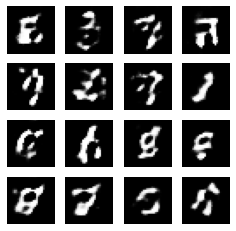

Epoch time is 23.758009433746338 sec
> 18 | 1/256 | 1.1484037637710571 | 0.925508975982666
> 18 | 2/256 | 1.203837275505066 | 0.8614100217819214
> 18 | 3/256 | 1.3662364482879639 | 0.9554389119148254
> 18 | 4/256 | 1.40041184425354 | 0.9962201118469238
> 18 | 5/256 | 1.2964404821395874 | 0.9828360080718994
> 18 | 6/256 | 1.2071728706359863 | 0.9521992206573486
> 18 | 7/256 | 1.2010719776153564 | 0.8617186546325684
> 18 | 8/256 | 1.150921106338501 | 0.9470735788345337
> 18 | 9/256 | 1.3158563375473022 | 0.8843163847923279
> 18 | 10/256 | 1.422602891921997 | 1.005494475364685
> 18 | 11/256 | 1.413267970085144 | 0.9668011665344238
> 18 | 12/256 | 1.217372179031372 | 0.9810831546783447
> 18 | 13/256 | 1.1138036251068115 | 0.9976118803024292
> 18 | 14/256 | 1.1152504682540894 | 0.9849562048912048
> 18 | 15/256 | 1.1862783432006836 | 1.0148320198059082
> 18 | 16/256 | 1.31715989112854 | 0.9887285828590393
> 18 | 17/256 | 1.2580294609069824 | 1.0379517078399658
> 18 | 18/256 | 1.2411233186721

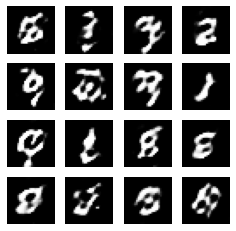

Epoch time is 23.878979682922363 sec
> 19 | 1/256 | 1.2352044582366943 | 1.105397343635559
> 19 | 2/256 | 1.251389503479004 | 1.090998649597168
> 19 | 3/256 | 1.184694528579712 | 1.1714147329330444
> 19 | 4/256 | 1.1238734722137451 | 1.0389094352722168
> 19 | 5/256 | 0.975790798664093 | 1.0925793647766113
> 19 | 6/256 | 0.9914553761482239 | 1.0830737352371216
> 19 | 7/256 | 1.272130012512207 | 1.088474988937378
> 19 | 8/256 | 1.3589537143707275 | 1.0916295051574707
> 19 | 9/256 | 1.1207281351089478 | 1.129007339477539
> 19 | 10/256 | 1.0681806802749634 | 1.137389898300171
> 19 | 11/256 | 0.9968631863594055 | 1.1001834869384766
> 19 | 12/256 | 1.0697181224822998 | 1.1174798011779785
> 19 | 13/256 | 1.1082918643951416 | 1.2161078453063965
> 19 | 14/256 | 1.1641600131988525 | 1.197150707244873
> 19 | 15/256 | 1.1363946199417114 | 1.111663579940796
> 19 | 16/256 | 0.99994957447052 | 1.1561143398284912
> 19 | 17/256 | 0.9281921982765198 | 1.1887924671173096
> 19 | 18/256 | 1.063860297203064

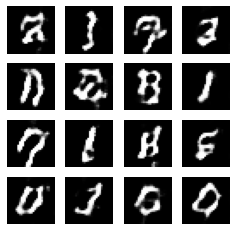

Epoch time is 23.960418224334717 sec
> 20 | 1/256 | 1.3171296119689941 | 0.9548326730728149
> 20 | 2/256 | 1.2815099954605103 | 0.9683942794799805
> 20 | 3/256 | 1.1681194305419922 | 1.0752935409545898
> 20 | 4/256 | 1.251861572265625 | 0.9349141120910645
> 20 | 5/256 | 1.2988816499710083 | 0.9878745079040527
> 20 | 6/256 | 1.3457282781600952 | 0.9914348721504211
> 20 | 7/256 | 1.3014540672302246 | 0.9137142896652222
> 20 | 8/256 | 1.1969847679138184 | 1.0660984516143799
> 20 | 9/256 | 1.1802618503570557 | 1.0566285848617554
> 20 | 10/256 | 1.161273717880249 | 1.1141986846923828
> 20 | 11/256 | 1.2854994535446167 | 0.9914549589157104
> 20 | 12/256 | 1.2045080661773682 | 1.1184136867523193
> 20 | 13/256 | 1.2142901420593262 | 1.0579807758331299
> 20 | 14/256 | 1.120680332183838 | 1.0758709907531738
> 20 | 15/256 | 1.1732360124588013 | 1.0922738313674927
> 20 | 16/256 | 1.1698760986328125 | 1.085050344467163
> 20 | 17/256 | 1.124548316001892 | 1.1238887310028076
> 20 | 18/256 | 1.0996277

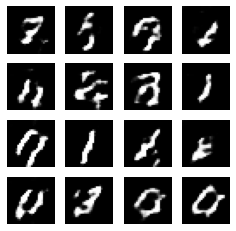

Epoch time is 23.7379789352417 sec
> 21 | 1/256 | 1.2738286256790161 | 0.8956977725028992
> 21 | 2/256 | 1.2985820770263672 | 0.9455963373184204
> 21 | 3/256 | 1.3139854669570923 | 0.9643399715423584
> 21 | 4/256 | 1.3413513898849487 | 0.903174877166748
> 21 | 5/256 | 1.4432324171066284 | 0.9603918194770813
> 21 | 6/256 | 1.3640483617782593 | 0.9417386651039124
> 21 | 7/256 | 1.223039984703064 | 0.9481509923934937
> 21 | 8/256 | 1.3470550775527954 | 0.8620737791061401
> 21 | 9/256 | 1.4261709451675415 | 0.9966721534729004
> 21 | 10/256 | 1.3842692375183105 | 0.9534218311309814
> 21 | 11/256 | 1.31134033203125 | 0.9454476833343506
> 21 | 12/256 | 1.2513813972473145 | 0.9005692005157471
> 21 | 13/256 | 1.386702060699463 | 0.9302176237106323
> 21 | 14/256 | 1.447737455368042 | 0.9175854921340942
> 21 | 15/256 | 1.286685824394226 | 0.9194200038909912
> 21 | 16/256 | 1.3223469257354736 | 0.990848958492279
> 21 | 17/256 | 1.2527230978012085 | 1.018005132675171
> 21 | 18/256 | 1.3775966167449

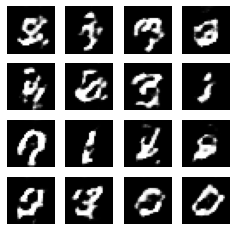

Epoch time is 23.791077136993408 sec
> 22 | 1/256 | 1.2251404523849487 | 1.00542414188385
> 22 | 2/256 | 1.1754275560379028 | 1.016981601715088
> 22 | 3/256 | 1.1913657188415527 | 1.0032966136932373
> 22 | 4/256 | 1.2907215356826782 | 1.0353343486785889
> 22 | 5/256 | 1.3298754692077637 | 1.020577073097229
> 22 | 6/256 | 1.2074811458587646 | 1.084667444229126
> 22 | 7/256 | 1.1286251544952393 | 1.0147855281829834
> 22 | 8/256 | 1.0703434944152832 | 1.1101876497268677
> 22 | 9/256 | 1.1759381294250488 | 1.03214693069458
> 22 | 10/256 | 1.361610770225525 | 1.051826000213623
> 22 | 11/256 | 1.3624597787857056 | 1.050337314605713
> 22 | 12/256 | 1.18528151512146 | 1.0697386264801025
> 22 | 13/256 | 1.127974033355713 | 1.0276036262512207
> 22 | 14/256 | 1.10516357421875 | 1.083008050918579
> 22 | 15/256 | 1.1804481744766235 | 1.0457137823104858
> 22 | 16/256 | 1.2354117631912231 | 1.102154016494751
> 22 | 17/256 | 1.2524526119232178 | 1.0532617568969727
> 22 | 18/256 | 1.2388966083526611 | 

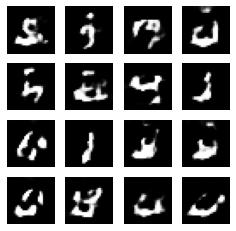

Epoch time is 23.938907861709595 sec
> 23 | 1/256 | 1.3336261510849 | 0.9882763624191284
> 23 | 2/256 | 1.2282434701919556 | 0.9968591332435608
> 23 | 3/256 | 1.3610366582870483 | 0.8995651602745056
> 23 | 4/256 | 1.4016385078430176 | 0.8969444632530212
> 23 | 5/256 | 1.5624728202819824 | 0.9495108127593994
> 23 | 6/256 | 1.465912103652954 | 0.9781961441040039
> 23 | 7/256 | 1.3665961027145386 | 0.9267545342445374
> 23 | 8/256 | 1.378749132156372 | 0.9450889825820923
> 23 | 9/256 | 1.2681009769439697 | 1.0132005214691162
> 23 | 10/256 | 1.2359026670455933 | 1.0250734090805054
> 23 | 11/256 | 1.2488511800765991 | 1.0346713066101074
> 23 | 12/256 | 1.32780122756958 | 0.9804000854492188
> 23 | 13/256 | 1.3432352542877197 | 0.9991408586502075
> 23 | 14/256 | 1.4625608921051025 | 0.9521065950393677
> 23 | 15/256 | 1.3167487382888794 | 1.0130352973937988
> 23 | 16/256 | 1.2472492456436157 | 0.9810713529586792
> 23 | 17/256 | 1.3507249355316162 | 1.0009976625442505
> 23 | 18/256 | 1.304152727

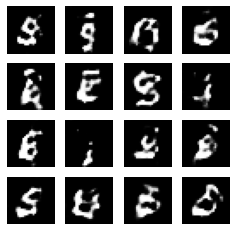

Epoch time is 23.778401136398315 sec
> 24 | 1/256 | 1.2194448709487915 | 1.025092363357544
> 24 | 2/256 | 1.3363590240478516 | 0.9117251038551331
> 24 | 3/256 | 1.3530877828598022 | 0.9687888622283936
> 24 | 4/256 | 1.5283944606781006 | 0.9247537851333618
> 24 | 5/256 | 1.5441691875457764 | 0.9128676652908325
> 24 | 6/256 | 1.3481999635696411 | 0.9885566234588623
> 24 | 7/256 | 1.2053258419036865 | 0.9473743438720703
> 24 | 8/256 | 1.2015941143035889 | 0.9222815632820129
> 24 | 9/256 | 1.451308250427246 | 0.9437911510467529
> 24 | 10/256 | 1.5879664421081543 | 1.0253028869628906
> 24 | 11/256 | 1.4245519638061523 | 0.92915940284729
> 24 | 12/256 | 1.3253151178359985 | 0.9576001167297363
> 24 | 13/256 | 1.3977723121643066 | 0.8915511965751648
> 24 | 14/256 | 1.303217887878418 | 0.932826817035675
> 24 | 15/256 | 1.2935267686843872 | 0.9642022848129272
> 24 | 16/256 | 1.519917607307434 | 0.906159520149231
> 24 | 17/256 | 1.560982584953308 | 0.9135246872901917
> 24 | 18/256 | 1.47333085536

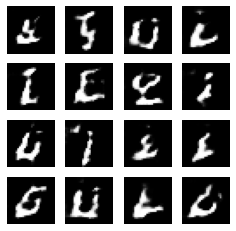

Epoch time is 23.77131414413452 sec
> 25 | 1/256 | 1.7254018783569336 | 0.7045446634292603
> 25 | 2/256 | 1.6448496580123901 | 0.748062014579773
> 25 | 3/256 | 1.5799224376678467 | 0.7201728820800781
> 25 | 4/256 | 1.6041725873947144 | 0.782930314540863
> 25 | 5/256 | 1.5705257654190063 | 0.7689144015312195
> 25 | 6/256 | 1.6739369630813599 | 0.7117639183998108
> 25 | 7/256 | 1.718565583229065 | 0.7426339387893677
> 25 | 8/256 | 1.5586541891098022 | 0.815767765045166
> 25 | 9/256 | 1.4737187623977661 | 0.8130854368209839
> 25 | 10/256 | 1.402254581451416 | 0.8175323605537415
> 25 | 11/256 | 1.5234681367874146 | 0.7651022672653198
> 25 | 12/256 | 1.6082053184509277 | 0.7957768440246582
> 25 | 13/256 | 1.6016958951950073 | 0.8892710208892822
> 25 | 14/256 | 1.4209920167922974 | 0.8326032161712646
> 25 | 15/256 | 1.3806227445602417 | 0.8254843950271606
> 25 | 16/256 | 1.4123868942260742 | 0.8446022272109985
> 25 | 17/256 | 1.5468018054962158 | 0.8604384660720825
> 25 | 18/256 | 1.58108174

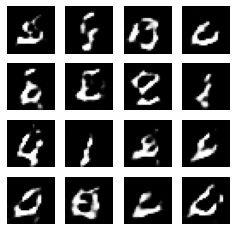

Epoch time is 23.967798709869385 sec
> 26 | 1/256 | 1.2984721660614014 | 0.8847420811653137
> 26 | 2/256 | 1.3268215656280518 | 0.9039846062660217
> 26 | 3/256 | 1.436834692955017 | 0.7811616659164429
> 26 | 4/256 | 1.6093679666519165 | 0.87911057472229
> 26 | 5/256 | 1.5304316282272339 | 0.8459165096282959
> 26 | 6/256 | 1.349210262298584 | 0.8335497975349426
> 26 | 7/256 | 1.3609235286712646 | 0.8197954893112183
> 26 | 8/256 | 1.4099713563919067 | 0.7624268531799316
> 26 | 9/256 | 1.5441607236862183 | 0.8167837858200073
> 26 | 10/256 | 1.575376272201538 | 0.8169101476669312
> 26 | 11/256 | 1.561772346496582 | 0.7815550565719604
> 26 | 12/256 | 1.3486695289611816 | 0.7888399362564087
> 26 | 13/256 | 1.4371743202209473 | 0.8163174390792847
> 26 | 14/256 | 1.5365079641342163 | 0.8490442037582397
> 26 | 15/256 | 1.5310462713241577 | 0.7903186082839966
> 26 | 16/256 | 1.5951635837554932 | 0.7539559602737427
> 26 | 17/256 | 1.5270951986312866 | 0.7104455232620239
> 26 | 18/256 | 1.47464036

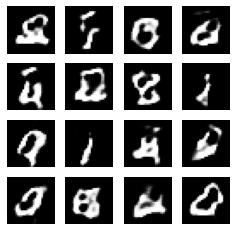

Epoch time is 23.789132356643677 sec
> 27 | 1/256 | 1.0569005012512207 | 1.1520428657531738
> 27 | 2/256 | 1.2651481628417969 | 1.1143279075622559
> 27 | 3/256 | 1.3272855281829834 | 1.1133642196655273
> 27 | 4/256 | 1.1480504274368286 | 1.1393173933029175
> 27 | 5/256 | 1.088956356048584 | 1.1458799839019775
> 27 | 6/256 | 1.060276985168457 | 1.1450790166854858
> 27 | 7/256 | 1.1203550100326538 | 1.177740454673767
> 27 | 8/256 | 1.1891257762908936 | 1.1492047309875488
> 27 | 9/256 | 1.2927825450897217 | 1.0446031093597412
> 27 | 10/256 | 1.161028504371643 | 1.1098768711090088
> 27 | 11/256 | 1.1894173622131348 | 1.1415643692016602
> 27 | 12/256 | 1.2216405868530273 | 1.1006349325180054
> 27 | 13/256 | 1.2200989723205566 | 1.131534218788147
> 27 | 14/256 | 1.1877000331878662 | 1.157071828842163
> 27 | 15/256 | 1.2167611122131348 | 1.113654375076294
> 27 | 16/256 | 1.262715220451355 | 1.1878952980041504
> 27 | 17/256 | 1.2848628759384155 | 1.1398003101348877
> 27 | 18/256 | 1.3222981691

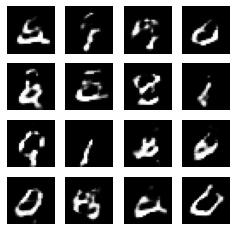

Epoch time is 23.724111080169678 sec
> 28 | 1/256 | 1.2561402320861816 | 1.0784549713134766
> 28 | 2/256 | 1.2794896364212036 | 1.0790470838546753
> 28 | 3/256 | 1.2305452823638916 | 1.098801851272583
> 28 | 4/256 | 1.252999186515808 | 1.1470226049423218
> 28 | 5/256 | 1.2856577634811401 | 1.0848828554153442
> 28 | 6/256 | 1.2534551620483398 | 1.033826231956482
> 28 | 7/256 | 1.2861194610595703 | 1.070391058921814
> 28 | 8/256 | 1.3214471340179443 | 1.0628459453582764
> 28 | 9/256 | 1.3260363340377808 | 1.0076833963394165
> 28 | 10/256 | 1.2674875259399414 | 1.1100645065307617
> 28 | 11/256 | 1.3824851512908936 | 1.1134755611419678
> 28 | 12/256 | 1.2788023948669434 | 1.0965157747268677
> 28 | 13/256 | 1.1391534805297852 | 1.003601312637329
> 28 | 14/256 | 1.2136980295181274 | 1.0480372905731201
> 28 | 15/256 | 1.296012282371521 | 1.1409707069396973
> 28 | 16/256 | 1.290359616279602 | 1.0405194759368896
> 28 | 17/256 | 1.381547212600708 | 1.0668017864227295
> 28 | 18/256 | 1.3325649499

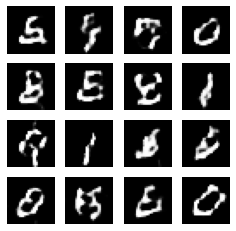

Epoch time is 23.911442041397095 sec
> 29 | 1/256 | 1.043113112449646 | 1.1571745872497559
> 29 | 2/256 | 1.1156059503555298 | 1.1564408540725708
> 29 | 3/256 | 1.135657548904419 | 1.1629246473312378
> 29 | 4/256 | 1.2593599557876587 | 1.2263703346252441
> 29 | 5/256 | 1.3108412027359009 | 1.085747241973877
> 29 | 6/256 | 1.1189831495285034 | 1.1507478952407837
> 29 | 7/256 | 1.1226694583892822 | 1.0681109428405762
> 29 | 8/256 | 1.0878968238830566 | 1.0680919885635376
> 29 | 9/256 | 1.1817114353179932 | 1.0501506328582764
> 29 | 10/256 | 1.4002952575683594 | 1.0384474992752075
> 29 | 11/256 | 1.4014477729797363 | 1.0699986219406128
> 29 | 12/256 | 1.1270817518234253 | 1.0586915016174316
> 29 | 13/256 | 1.1488498449325562 | 0.9746848940849304
> 29 | 14/256 | 1.209671974182129 | 1.0319759845733643
> 29 | 15/256 | 1.3882986307144165 | 1.0087990760803223
> 29 | 16/256 | 1.3485074043273926 | 1.0213037729263306
> 29 | 17/256 | 1.3185126781463623 | 0.9552887082099915
> 29 | 18/256 | 1.197934

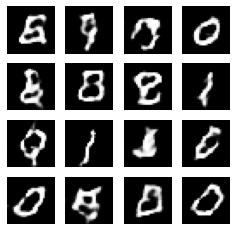

Epoch time is 23.745814085006714 sec
> 30 | 1/256 | 0.9033129811286926 | 1.2471987009048462
> 30 | 2/256 | 1.0650959014892578 | 1.1668765544891357
> 30 | 3/256 | 1.1208025217056274 | 1.2055790424346924
> 30 | 4/256 | 1.123687982559204 | 1.2066679000854492
> 30 | 5/256 | 0.9498770236968994 | 1.192072868347168
> 30 | 6/256 | 0.9733360409736633 | 1.1764346361160278
> 30 | 7/256 | 1.1087299585342407 | 1.158358097076416
> 30 | 8/256 | 1.1053529977798462 | 1.2458534240722656
> 30 | 9/256 | 1.0754951238632202 | 1.2348129749298096
> 30 | 10/256 | 1.0536599159240723 | 1.1468391418457031
> 30 | 11/256 | 0.9976047873497009 | 1.2112476825714111
> 30 | 12/256 | 1.0665628910064697 | 1.2032599449157715
> 30 | 13/256 | 1.083892583847046 | 1.085845708847046
> 30 | 14/256 | 1.0828468799591064 | 1.11061429977417
> 30 | 15/256 | 1.1242380142211914 | 1.1209051609039307
> 30 | 16/256 | 0.9992626905441284 | 1.2045453786849976
> 30 | 17/256 | 1.030463695526123 | 1.1521445512771606
> 30 | 18/256 | 1.0349807739

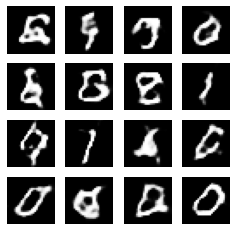

Epoch time is 23.85757827758789 sec
> 31 | 1/256 | 1.0854395627975464 | 1.1747527122497559
> 31 | 2/256 | 1.073993444442749 | 1.1141308546066284
> 31 | 3/256 | 1.149460792541504 | 1.219125747680664
> 31 | 4/256 | 1.0359582901000977 | 1.1389238834381104
> 31 | 5/256 | 1.0404775142669678 | 1.1703822612762451
> 31 | 6/256 | 0.9306806325912476 | 1.2180609703063965
> 31 | 7/256 | 0.9611861705780029 | 1.2359973192214966
> 31 | 8/256 | 1.0994057655334473 | 1.1156190633773804
> 31 | 9/256 | 1.1179466247558594 | 1.1550078392028809
> 31 | 10/256 | 1.1195311546325684 | 1.2276991605758667
> 31 | 11/256 | 1.0122555494308472 | 1.1914966106414795
> 31 | 12/256 | 0.9921473264694214 | 1.2159031629562378
> 31 | 13/256 | 1.0081288814544678 | 1.2605929374694824
> 31 | 14/256 | 1.102490782737732 | 1.2124979496002197
> 31 | 15/256 | 1.0693895816802979 | 1.2035884857177734
> 31 | 16/256 | 1.0219937562942505 | 1.235471248626709
> 31 | 17/256 | 0.9958547353744507 | 1.2021522521972656
> 31 | 18/256 | 1.04343104

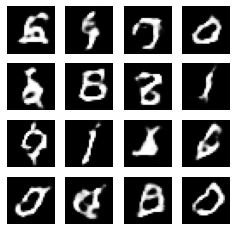

Epoch time is 23.885048866271973 sec
> 32 | 1/256 | 0.8456735014915466 | 1.2391167879104614
> 32 | 2/256 | 0.9404054284095764 | 1.1854591369628906
> 32 | 3/256 | 1.1148090362548828 | 1.1975600719451904
> 32 | 4/256 | 1.189244031906128 | 1.213541030883789
> 32 | 5/256 | 1.164246916770935 | 1.2479366064071655
> 32 | 6/256 | 1.0505048036575317 | 1.1382551193237305
> 32 | 7/256 | 0.8478589057922363 | 1.2745957374572754
> 32 | 8/256 | 0.8168531060218811 | 1.250211238861084
> 32 | 9/256 | 1.0006773471832275 | 1.209712266921997
> 32 | 10/256 | 1.1161774396896362 | 1.2752927541732788
> 32 | 11/256 | 1.2014731168746948 | 1.2110974788665771
> 32 | 12/256 | 1.11481773853302 | 1.2635611295700073
> 32 | 13/256 | 0.9644841551780701 | 1.1897540092468262
> 32 | 14/256 | 0.9408788681030273 | 1.2166526317596436
> 32 | 15/256 | 0.9184459447860718 | 1.2970075607299805
> 32 | 16/256 | 1.1118698120117188 | 1.1531238555908203
> 32 | 17/256 | 1.1198593378067017 | 1.1712663173675537
> 32 | 18/256 | 1.175155043

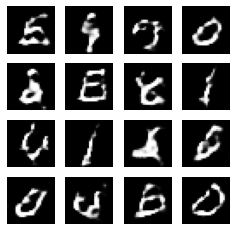

Epoch time is 23.774488925933838 sec
> 33 | 1/256 | 1.2495678663253784 | 0.9343857765197754
> 33 | 2/256 | 1.1095644235610962 | 0.9697161316871643
> 33 | 3/256 | 1.2351630926132202 | 0.9453164339065552
> 33 | 4/256 | 1.410703182220459 | 0.8774624466896057
> 33 | 5/256 | 1.5560977458953857 | 0.9485461711883545
> 33 | 6/256 | 1.4072946310043335 | 0.9836233854293823
> 33 | 7/256 | 1.3052399158477783 | 0.9448255896568298
> 33 | 8/256 | 1.091966986656189 | 0.9903770685195923
> 33 | 9/256 | 1.1459819078445435 | 0.9710955023765564
> 33 | 10/256 | 1.2109627723693848 | 1.021316409111023
> 33 | 11/256 | 1.3746949434280396 | 0.9713889956474304
> 33 | 12/256 | 1.397383451461792 | 0.9723262786865234
> 33 | 13/256 | 1.297412633895874 | 0.9661765098571777
> 33 | 14/256 | 1.2422051429748535 | 1.0013750791549683
> 33 | 15/256 | 1.0966721773147583 | 1.0439560413360596
> 33 | 16/256 | 1.1308069229125977 | 1.0566954612731934
> 33 | 17/256 | 1.2234716415405273 | 1.0649330615997314
> 33 | 18/256 | 1.2745431

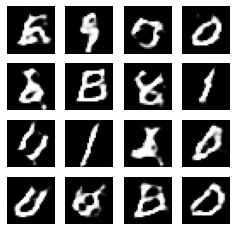

Epoch time is 23.84682869911194 sec
> 34 | 1/256 | 1.0461236238479614 | 1.0884246826171875
> 34 | 2/256 | 1.0467345714569092 | 1.0987284183502197
> 34 | 3/256 | 1.068848967552185 | 1.078955054283142
> 34 | 4/256 | 1.2545775175094604 | 1.0900245904922485
> 34 | 5/256 | 1.138926386833191 | 1.103514552116394
> 34 | 6/256 | 1.1888368129730225 | 1.0820353031158447
> 34 | 7/256 | 1.1581889390945435 | 1.101386547088623
> 34 | 8/256 | 1.0614978075027466 | 1.1097633838653564
> 34 | 9/256 | 1.0226889848709106 | 1.1359531879425049
> 34 | 10/256 | 1.1107275485992432 | 1.1147723197937012
> 34 | 11/256 | 1.168051838874817 | 1.0707168579101562
> 34 | 12/256 | 1.278670072555542 | 1.0263047218322754
> 34 | 13/256 | 1.2193222045898438 | 1.071892499923706
> 34 | 14/256 | 1.1653612852096558 | 1.0520648956298828
> 34 | 15/256 | 1.1031039953231812 | 1.1096851825714111
> 34 | 16/256 | 1.1463812589645386 | 1.0476112365722656
> 34 | 17/256 | 1.1416351795196533 | 1.0869574546813965
> 34 | 18/256 | 1.15250945091

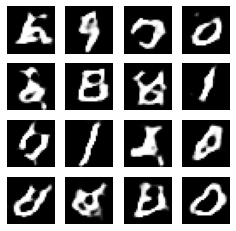

Epoch time is 24.000494480133057 sec
> 35 | 1/256 | 1.1399555206298828 | 1.1083858013153076
> 35 | 2/256 | 1.1639500856399536 | 1.054664969444275
> 35 | 3/256 | 1.2256382703781128 | 1.0431921482086182
> 35 | 4/256 | 1.2025995254516602 | 0.9620884656906128
> 35 | 5/256 | 1.20512855052948 | 1.0301353931427002
> 35 | 6/256 | 1.129823088645935 | 0.97489994764328
> 35 | 7/256 | 1.2286841869354248 | 1.0048785209655762
> 35 | 8/256 | 1.3246185779571533 | 0.8809417486190796
> 35 | 9/256 | 1.3832981586456299 | 0.9495975971221924
> 35 | 10/256 | 1.5273914337158203 | 0.9469701647758484
> 35 | 11/256 | 1.3910531997680664 | 0.8793514370918274
> 35 | 12/256 | 1.3105125427246094 | 0.8774919509887695
> 35 | 13/256 | 1.251128077507019 | 0.9315696954727173
> 35 | 14/256 | 1.3943268060684204 | 0.8808920383453369
> 35 | 15/256 | 1.3887710571289062 | 0.8569808006286621
> 35 | 16/256 | 1.4846713542938232 | 0.9121361970901489
> 35 | 17/256 | 1.5117830038070679 | 0.8534868955612183
> 35 | 18/256 | 1.412634134

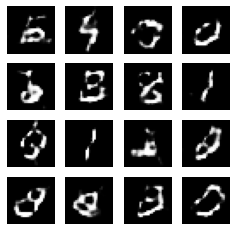

Epoch time is 23.774502515792847 sec
> 36 | 1/256 | 1.1229361295700073 | 1.1104577779769897
> 36 | 2/256 | 1.1612356901168823 | 1.2076302766799927
> 36 | 3/256 | 1.17183518409729 | 1.065827488899231
> 36 | 4/256 | 1.1618536710739136 | 1.0606944561004639
> 36 | 5/256 | 1.066169023513794 | 1.0775537490844727
> 36 | 6/256 | 1.094911813735962 | 1.0761919021606445
> 36 | 7/256 | 1.248258113861084 | 0.9571912288665771
> 36 | 8/256 | 1.3280977010726929 | 0.9557945132255554
> 36 | 9/256 | 1.252334475517273 | 0.9134775400161743
> 36 | 10/256 | 1.2414745092391968 | 0.9608700275421143
> 36 | 11/256 | 1.256186604499817 | 0.8989073038101196
> 36 | 12/256 | 1.2551366090774536 | 0.9368894100189209
> 36 | 13/256 | 1.2906432151794434 | 0.9522213339805603
> 36 | 14/256 | 1.3728013038635254 | 0.9128106832504272
> 36 | 15/256 | 1.3391116857528687 | 0.9032496809959412
> 36 | 16/256 | 1.3651708364486694 | 0.8703463077545166
> 36 | 17/256 | 1.2948259115219116 | 0.8754900693893433
> 36 | 18/256 | 1.2965570688

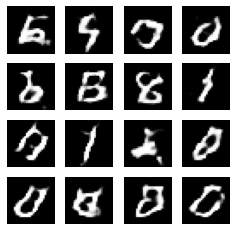

Epoch time is 23.747785568237305 sec
> 37 | 1/256 | 1.0342103242874146 | 1.1871010065078735
> 37 | 2/256 | 0.9189086556434631 | 1.299896478652954
> 37 | 3/256 | 0.9685057997703552 | 1.2192457914352417
> 37 | 4/256 | 1.0288101434707642 | 1.3138823509216309
> 37 | 5/256 | 1.160753607749939 | 1.2183914184570312
> 37 | 6/256 | 1.0087412595748901 | 1.2883293628692627
> 37 | 7/256 | 0.8732737898826599 | 1.308440923690796
> 37 | 8/256 | 0.8468374609947205 | 1.375464677810669
> 37 | 9/256 | 0.8782030940055847 | 1.3396406173706055
> 37 | 10/256 | 1.0103447437286377 | 1.2886111736297607
> 37 | 11/256 | 1.0484986305236816 | 1.3478349447250366
> 37 | 12/256 | 0.9799187779426575 | 1.3101136684417725
> 37 | 13/256 | 0.8744872808456421 | 1.3339457511901855
> 37 | 14/256 | 0.789336085319519 | 1.3580238819122314
> 37 | 15/256 | 0.8408852815628052 | 1.2871451377868652
> 37 | 16/256 | 0.8795908689498901 | 1.335367202758789
> 37 | 17/256 | 0.9919059872627258 | 1.2036892175674438
> 37 | 18/256 | 1.02984929

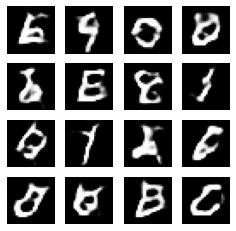

Epoch time is 23.892247915267944 sec
> 38 | 1/256 | 0.9783785343170166 | 1.2130721807479858
> 38 | 2/256 | 0.9809397459030151 | 1.147812843322754
> 38 | 3/256 | 1.0753532648086548 | 1.1265361309051514
> 38 | 4/256 | 0.9951186180114746 | 1.1339808702468872
> 38 | 5/256 | 0.9230902791023254 | 1.1549162864685059
> 38 | 6/256 | 1.0909665822982788 | 1.1278204917907715
> 38 | 7/256 | 1.066150426864624 | 1.1578803062438965
> 38 | 8/256 | 1.0415312051773071 | 1.1676346063613892
> 38 | 9/256 | 1.1207399368286133 | 1.123152732849121
> 38 | 10/256 | 1.011608362197876 | 1.1166508197784424
> 38 | 11/256 | 0.9832369089126587 | 1.096381425857544
> 38 | 12/256 | 1.0297763347625732 | 1.1003046035766602
> 38 | 13/256 | 1.0660699605941772 | 1.1669913530349731
> 38 | 14/256 | 1.1130855083465576 | 1.0989348888397217
> 38 | 15/256 | 1.155658483505249 | 1.1011831760406494
> 38 | 16/256 | 1.1015331745147705 | 1.1098014116287231
> 38 | 17/256 | 1.0255157947540283 | 1.1513597965240479
> 38 | 18/256 | 1.00577533

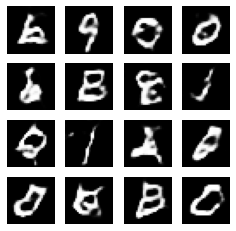

Epoch time is 23.780071020126343 sec
> 39 | 1/256 | 0.9834067225456238 | 1.2177565097808838
> 39 | 2/256 | 0.9857566356658936 | 1.2546441555023193
> 39 | 3/256 | 1.0058047771453857 | 1.322892665863037
> 39 | 4/256 | 0.9921646118164062 | 1.2615599632263184
> 39 | 5/256 | 0.8740326762199402 | 1.2402088642120361
> 39 | 6/256 | 0.9111140370368958 | 1.273695707321167
> 39 | 7/256 | 0.9395850896835327 | 1.2908433675765991
> 39 | 8/256 | 0.9706616997718811 | 1.2328221797943115
> 39 | 9/256 | 0.9363661408424377 | 1.2193008661270142
> 39 | 10/256 | 0.9485189914703369 | 1.1915050745010376
> 39 | 11/256 | 0.9814420938491821 | 1.1886658668518066
> 39 | 12/256 | 0.9578621983528137 | 1.2691874504089355
> 39 | 13/256 | 1.0036818981170654 | 1.208499550819397
> 39 | 14/256 | 0.9696581959724426 | 1.1712493896484375
> 39 | 15/256 | 0.9626030921936035 | 1.2192457914352417
> 39 | 16/256 | 0.9479730725288391 | 1.17753267288208
> 39 | 17/256 | 0.986088752746582 | 1.181122064590454
> 39 | 18/256 | 1.026291847

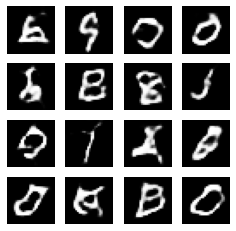

Epoch time is 23.821722745895386 sec
> 40 | 1/256 | 0.9880988001823425 | 1.229717493057251
> 40 | 2/256 | 0.99406898021698 | 1.171828031539917
> 40 | 3/256 | 0.989254891872406 | 1.2335808277130127
> 40 | 4/256 | 0.9252079129219055 | 1.2454886436462402
> 40 | 5/256 | 0.8864046335220337 | 1.2887911796569824
> 40 | 6/256 | 0.9740713238716125 | 1.2070329189300537
> 40 | 7/256 | 0.9197755455970764 | 1.2987388372421265
> 40 | 8/256 | 0.9000075459480286 | 1.1855833530426025
> 40 | 9/256 | 0.9721196889877319 | 1.2343976497650146
> 40 | 10/256 | 0.9796497225761414 | 1.253298044204712
> 40 | 11/256 | 1.0403928756713867 | 1.2297511100769043
> 40 | 12/256 | 0.9050455093383789 | 1.2351386547088623
> 40 | 13/256 | 0.9283697009086609 | 1.2125098705291748
> 40 | 14/256 | 0.9119561910629272 | 1.1738240718841553
> 40 | 15/256 | 1.0119692087173462 | 1.2603061199188232
> 40 | 16/256 | 0.9430944323539734 | 1.293461799621582
> 40 | 17/256 | 0.9537104964256287 | 1.1950792074203491
> 40 | 18/256 | 0.965438485

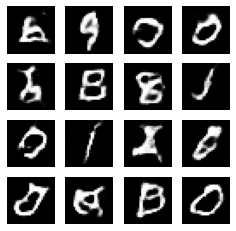

Epoch time is 23.9121572971344 sec
> 41 | 1/256 | 1.0012775659561157 | 1.1614384651184082
> 41 | 2/256 | 0.9608194828033447 | 1.1745116710662842
> 41 | 3/256 | 1.0179799795150757 | 1.1914598941802979
> 41 | 4/256 | 0.9316359162330627 | 1.2181272506713867
> 41 | 5/256 | 1.0246176719665527 | 1.2032749652862549
> 41 | 6/256 | 1.0142097473144531 | 1.1502561569213867
> 41 | 7/256 | 1.0004873275756836 | 1.1894359588623047
> 41 | 8/256 | 1.083554744720459 | 1.1579720973968506
> 41 | 9/256 | 0.9683684706687927 | 1.2564588785171509
> 41 | 10/256 | 0.9580539464950562 | 1.2131872177124023
> 41 | 11/256 | 0.9170724153518677 | 1.1874257326126099
> 41 | 12/256 | 0.932912290096283 | 1.2307461500167847
> 41 | 13/256 | 1.0490697622299194 | 1.1648263931274414
> 41 | 14/256 | 1.0923049449920654 | 1.2102091312408447
> 41 | 15/256 | 0.9951907992362976 | 1.228746771812439
> 41 | 16/256 | 1.0032198429107666 | 1.182603359222412
> 41 | 17/256 | 0.9294648170471191 | 1.2212320566177368
> 41 | 18/256 | 0.93685126

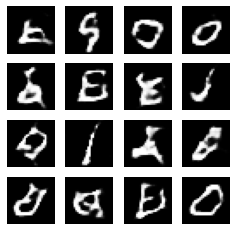

Epoch time is 23.84636425971985 sec
> 42 | 1/256 | 1.0136468410491943 | 1.265815258026123
> 42 | 2/256 | 1.0274543762207031 | 1.263176441192627
> 42 | 3/256 | 1.0055053234100342 | 1.1662561893463135
> 42 | 4/256 | 0.880462646484375 | 1.3184455633163452
> 42 | 5/256 | 0.896409273147583 | 1.2254295349121094
> 42 | 6/256 | 0.8755524754524231 | 1.2383546829223633
> 42 | 7/256 | 0.9721999168395996 | 1.234682321548462
> 42 | 8/256 | 1.0623215436935425 | 1.1838335990905762
> 42 | 9/256 | 0.9405059814453125 | 1.2387853860855103
> 42 | 10/256 | 0.9338406324386597 | 1.2175102233886719
> 42 | 11/256 | 0.9293744564056396 | 1.2884372472763062
> 42 | 12/256 | 0.9972981810569763 | 1.210315465927124
> 42 | 13/256 | 0.9966163039207458 | 1.290841817855835
> 42 | 14/256 | 0.9603031873703003 | 1.2260310649871826
> 42 | 15/256 | 0.9434263706207275 | 1.2583622932434082
> 42 | 16/256 | 0.9074554443359375 | 1.2434844970703125
> 42 | 17/256 | 0.9669568538665771 | 1.1880247592926025
> 42 | 18/256 | 0.9625102877

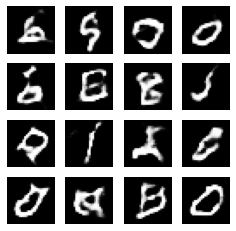

Epoch time is 23.746468782424927 sec
> 43 | 1/256 | 1.0867475271224976 | 1.1727646589279175
> 43 | 2/256 | 0.9640721678733826 | 1.175114393234253
> 43 | 3/256 | 0.9712978601455688 | 1.166222095489502
> 43 | 4/256 | 1.005373239517212 | 1.1964257955551147
> 43 | 5/256 | 1.0410834550857544 | 1.1648674011230469
> 43 | 6/256 | 1.0487208366394043 | 1.253472089767456
> 43 | 7/256 | 1.052375078201294 | 1.229401707649231
> 43 | 8/256 | 0.9547279477119446 | 1.2159515619277954
> 43 | 9/256 | 0.9195372462272644 | 1.2067471742630005
> 43 | 10/256 | 0.9983067512512207 | 1.193660020828247
> 43 | 11/256 | 0.9835043549537659 | 1.2008819580078125
> 43 | 12/256 | 1.0870648622512817 | 1.196516752243042
> 43 | 13/256 | 1.0796841382980347 | 1.182600498199463
> 43 | 14/256 | 0.995869517326355 | 1.2368173599243164
> 43 | 15/256 | 0.9261239171028137 | 1.2363616228103638
> 43 | 16/256 | 0.8946936726570129 | 1.2406284809112549
> 43 | 17/256 | 0.9198849201202393 | 1.2405036687850952
> 43 | 18/256 | 1.010663628578

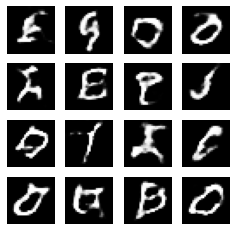

Epoch time is 23.9941246509552 sec
> 44 | 1/256 | 1.0724053382873535 | 1.271051049232483
> 44 | 2/256 | 0.9771678447723389 | 1.2083444595336914
> 44 | 3/256 | 0.7744345664978027 | 1.2303000688552856
> 44 | 4/256 | 0.798943042755127 | 1.2814552783966064
> 44 | 5/256 | 0.9652673006057739 | 1.197108507156372
> 44 | 6/256 | 1.122687578201294 | 1.2323856353759766
> 44 | 7/256 | 1.0916059017181396 | 1.1692063808441162
> 44 | 8/256 | 0.9723340272903442 | 1.2007614374160767
> 44 | 9/256 | 0.8358891010284424 | 1.2233433723449707
> 44 | 10/256 | 0.8481343984603882 | 1.2159327268600464
> 44 | 11/256 | 0.9900931119918823 | 1.2126214504241943
> 44 | 12/256 | 1.0137975215911865 | 1.2301268577575684
> 44 | 13/256 | 1.1566040515899658 | 1.1077911853790283
> 44 | 14/256 | 0.9768401384353638 | 1.2319003343582153
> 44 | 15/256 | 0.8658863306045532 | 1.274547815322876
> 44 | 16/256 | 0.8774645924568176 | 1.1781136989593506
> 44 | 17/256 | 0.9148921966552734 | 1.1893082857131958
> 44 | 18/256 | 0.977059543

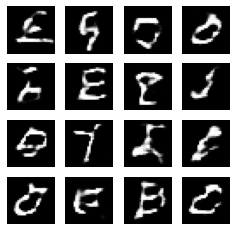

Epoch time is 23.74787473678589 sec
> 45 | 1/256 | 1.1466259956359863 | 1.1020678281784058
> 45 | 2/256 | 1.1414448022842407 | 1.0731372833251953
> 45 | 3/256 | 1.1442513465881348 | 1.0397803783416748
> 45 | 4/256 | 1.1456835269927979 | 0.9576441049575806
> 45 | 5/256 | 1.2494525909423828 | 0.9819966554641724
> 45 | 6/256 | 1.2563666105270386 | 0.9570461511611938
> 45 | 7/256 | 1.3269755840301514 | 0.930313229560852
> 45 | 8/256 | 1.2254310846328735 | 0.9728963375091553
> 45 | 9/256 | 1.2075883150100708 | 0.8484978079795837
> 45 | 10/256 | 1.207080364227295 | 0.8516875505447388
> 45 | 11/256 | 1.273310899734497 | 0.8176538944244385
> 45 | 12/256 | 1.4033403396606445 | 0.844497799873352
> 45 | 13/256 | 1.4901635646820068 | 0.8400781154632568
> 45 | 14/256 | 1.4055942296981812 | 0.8350660800933838
> 45 | 15/256 | 1.2801069021224976 | 0.8677151203155518
> 45 | 16/256 | 1.3122397661209106 | 0.834502100944519
> 45 | 17/256 | 1.261527419090271 | 0.8366661071777344
> 45 | 18/256 | 1.345166563

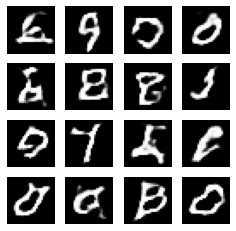

Epoch time is 23.817602396011353 sec
> 46 | 1/256 | 1.0787222385406494 | 1.2634687423706055
> 46 | 2/256 | 1.0102118253707886 | 1.295072078704834
> 46 | 3/256 | 0.8512383699417114 | 1.3195159435272217
> 46 | 4/256 | 0.8125451803207397 | 1.3157826662063599
> 46 | 5/256 | 0.8022099137306213 | 1.412870168685913
> 46 | 6/256 | 0.8357837200164795 | 1.329852819442749
> 46 | 7/256 | 0.9588623046875 | 1.2954905033111572
> 46 | 8/256 | 1.0215171575546265 | 1.3661803007125854
> 46 | 9/256 | 0.9356632232666016 | 1.3182618618011475
> 46 | 10/256 | 0.8442176580429077 | 1.3059015274047852
> 46 | 11/256 | 0.830995500087738 | 1.2582284212112427
> 46 | 12/256 | 0.8346874713897705 | 1.3346524238586426
> 46 | 13/256 | 0.9686404466629028 | 1.3160006999969482
> 46 | 14/256 | 0.9324934482574463 | 1.277415156364441
> 46 | 15/256 | 0.9336368441581726 | 1.3033421039581299
> 46 | 16/256 | 0.9884424209594727 | 1.2537486553192139
> 46 | 17/256 | 0.8672548532485962 | 1.319714069366455
> 46 | 18/256 | 0.88421016931

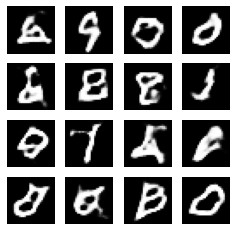

Epoch time is 23.98413324356079 sec
> 47 | 1/256 | 1.022615909576416 | 1.0771832466125488
> 47 | 2/256 | 0.9640128016471863 | 1.1495325565338135
> 47 | 3/256 | 0.9074860215187073 | 1.1544461250305176
> 47 | 4/256 | 0.9800519943237305 | 1.078749656677246
> 47 | 5/256 | 1.0985106229782104 | 1.0862030982971191
> 47 | 6/256 | 1.059083342552185 | 1.1083168983459473
> 47 | 7/256 | 1.1772273778915405 | 1.0497030019760132
> 47 | 8/256 | 1.0697849988937378 | 1.0884175300598145
> 47 | 9/256 | 1.098923683166504 | 1.144852638244629
> 47 | 10/256 | 1.0258086919784546 | 1.0594544410705566
> 47 | 11/256 | 1.051499605178833 | 1.1613268852233887
> 47 | 12/256 | 1.0265804529190063 | 1.1166538000106812
> 47 | 13/256 | 1.0862939357757568 | 1.1085023880004883
> 47 | 14/256 | 1.040837049484253 | 1.1342182159423828
> 47 | 15/256 | 1.0796087980270386 | 1.0924298763275146
> 47 | 16/256 | 1.0298552513122559 | 1.2148842811584473
> 47 | 17/256 | 1.0652707815170288 | 1.1645725965499878
> 47 | 18/256 | 1.0550550222

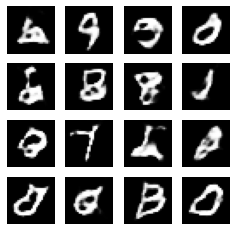

Epoch time is 23.741122484207153 sec
> 48 | 1/256 | 1.0073063373565674 | 1.2223212718963623
> 48 | 2/256 | 1.0226503610610962 | 1.2208607196807861
> 48 | 3/256 | 1.0094798803329468 | 1.2493648529052734
> 48 | 4/256 | 0.9715368747711182 | 1.2048392295837402
> 48 | 5/256 | 0.9550887942314148 | 1.2339980602264404
> 48 | 6/256 | 0.942902684211731 | 1.2630518674850464
> 48 | 7/256 | 0.9801529049873352 | 1.3059487342834473
> 48 | 8/256 | 0.9630858898162842 | 1.3159868717193604
> 48 | 9/256 | 0.9377851486206055 | 1.2862439155578613
> 48 | 10/256 | 1.0294770002365112 | 1.274743676185608
> 48 | 11/256 | 0.9632529020309448 | 1.3606959581375122
> 48 | 12/256 | 0.9047035574913025 | 1.3346168994903564
> 48 | 13/256 | 0.9609205722808838 | 1.285893201828003
> 48 | 14/256 | 0.9249550700187683 | 1.3333439826965332
> 48 | 15/256 | 0.9685953855514526 | 1.280867338180542
> 48 | 16/256 | 0.9622725248336792 | 1.3329432010650635
> 48 | 17/256 | 0.8910880088806152 | 1.337670922279358
> 48 | 18/256 | 0.9990606

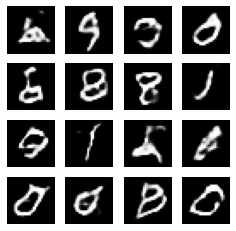

Epoch time is 23.804092407226562 sec
> 49 | 1/256 | 0.9753046035766602 | 1.33253014087677
> 49 | 2/256 | 0.9952248930931091 | 1.2961781024932861
> 49 | 3/256 | 0.9547854661941528 | 1.316734790802002
> 49 | 4/256 | 0.9457817077636719 | 1.2116389274597168
> 49 | 5/256 | 0.9320111274719238 | 1.2502657175064087
> 49 | 6/256 | 0.9410929679870605 | 1.2652533054351807
> 49 | 7/256 | 0.9925901293754578 | 1.2480348348617554
> 49 | 8/256 | 1.0560716390609741 | 1.31644606590271
> 49 | 9/256 | 0.9852005839347839 | 1.2771925926208496
> 49 | 10/256 | 0.9199669361114502 | 1.276895523071289
> 49 | 11/256 | 0.8326119184494019 | 1.335155725479126
> 49 | 12/256 | 0.900898814201355 | 1.2997450828552246
> 49 | 13/256 | 0.9706027507781982 | 1.2245426177978516
> 49 | 14/256 | 1.0339546203613281 | 1.32867431640625
> 49 | 15/256 | 1.0033855438232422 | 1.270395278930664
> 49 | 16/256 | 0.9605843424797058 | 1.254015564918518
> 49 | 17/256 | 1.0088138580322266 | 1.210203766822815
> 49 | 18/256 | 0.892759203910827

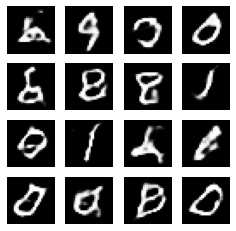

Epoch time is 23.93729329109192 sec
> 50 | 1/256 | 1.0054943561553955 | 1.2430516481399536
> 50 | 2/256 | 1.0704090595245361 | 1.1734262704849243
> 50 | 3/256 | 0.839839518070221 | 1.1999664306640625
> 50 | 4/256 | 0.9224604964256287 | 1.2655866146087646
> 50 | 5/256 | 0.8851079940795898 | 1.2556257247924805
> 50 | 6/256 | 0.9648094177246094 | 1.2435581684112549
> 50 | 7/256 | 0.9187802076339722 | 1.257340669631958
> 50 | 8/256 | 0.9822043180465698 | 1.2387919425964355
> 50 | 9/256 | 0.9937712550163269 | 1.2467442750930786
> 50 | 10/256 | 0.9253976941108704 | 1.2248653173446655
> 50 | 11/256 | 0.8803606033325195 | 1.2850265502929688
> 50 | 12/256 | 0.978925347328186 | 1.2818360328674316
> 50 | 13/256 | 0.9262323379516602 | 1.26547372341156
> 50 | 14/256 | 0.8998901844024658 | 1.2784559726715088
> 50 | 15/256 | 0.8777642250061035 | 1.3142595291137695
> 50 | 16/256 | 0.8879762291908264 | 1.3387112617492676
> 50 | 17/256 | 0.8941047191619873 | 1.2996599674224854
> 50 | 18/256 | 0.83590483

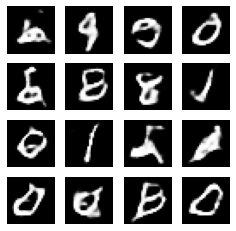

Epoch time is 23.857256412506104 sec
Total training time is 23.85733962059021 sec


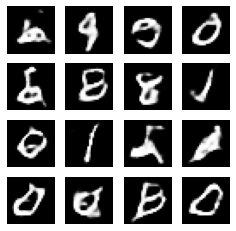

In [23]:
losses = train(train_dataset, EPOCHS)

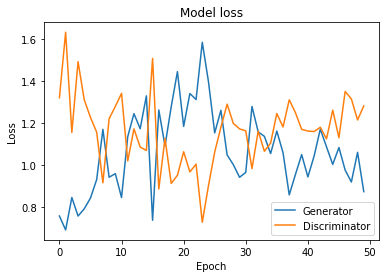

In [33]:
# Plot training & validation loss values

#print(losses)

gen_losses = [element[0] for element in losses]
disc_losses = [element[1] for element in losses]

#print(gen_losses)

plt.plot(gen_losses)
plt.plot(disc_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='lower right')
plt.show()

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # Restore the latest checkpoint.

## Create a GIF


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

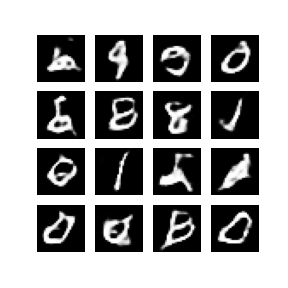

In [27]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [0]:
# If you're working in Colab you can download the animation with the code below:

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)